# `CNRatioModel` Tutorial

Trey V. Wenger (c) December 2024

`CNRatioModel` models both ${\rm CN}$ and $^{13}{\rm CN}$ spectral simultaneously in order to constrain the isotopic ratio $^{12}{\rm C}/^{13}{\rm C}$.

The ratio parameter `12C_13C_ratio` is only equivalent to the "true" isotopic ratio under the assumption that both species have the same excitation conditions (i.e., the same population fraction in the $N=0$ and $N=1$ states). This parameter is equivalent to the total column density ratio of all $N=0$ and $N=1$ states, $N_{\rm tot, CN}/N_{\rm tot, $13CN}$ where $N_{\rm tot} = \sum N_{N=0} + N_{N=1}$, which we assume is the same ratio over *all* states.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+6.ge3576a9.dirty


## Simulate Data

12CN-1 450
12CN-2 300
13CN-1 250
13CN-2 250
Transition 113144.19 is constraining upper state 1 from lower state 0
Transition 113191.325 is constraining upper state 0 from lower state 0
Transition 113490.985 is constraining upper state 4 from lower state 0
Transition 113508.934 is constraining upper state 3 from lower state 0
Transition 113520.4215 is constraining upper state 2 from lower state 0
Transition 113123.3687 is constraining lower state 1 from upper state 1
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]
Transition 108631.121 is constraining upper state 2 from lower state 1
Transition 108636.923 is constraining upper state 9 from lower state 1
Transition 108651.297 is constraining upper state 4 from lower state 1
Transition 108986.8678 is constraining upper state 7 from lower state 1
Transition 109217.6017 is constraining

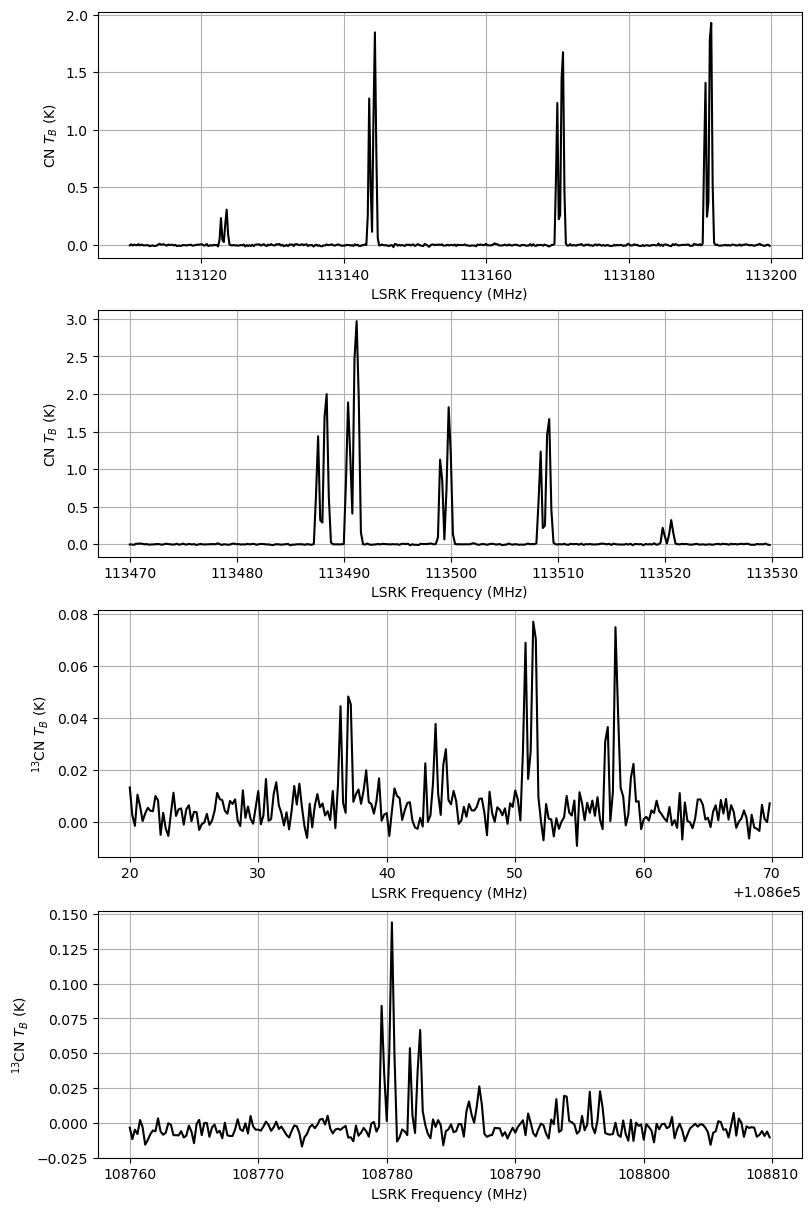

In [10]:
from bayes_spec import SpecData
from bayes_cn_hfs.cn_ratio_model import CNRatioModel

# spectral axis definition
freq_axis_12CN_1 = np.arange(113110.0, 113200.0, 0.2) # MHz
freq_axis_12CN_2 = np.arange(113470.0, 113530.0, 0.2) # MHz
freq_axis_13CN_1 = np.arange(108620.0, 108670.0, 0.2) # MHz
freq_axis_13CN_2 = np.arange(108760.0, 108810.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.005 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_12CN_1 = noise * np.random.randn(len(freq_axis_12CN_1)) # K
brightness_data_12CN_2 = noise * np.random.randn(len(freq_axis_12CN_2)) # K
brightness_data_13CN_1 = noise * np.random.randn(len(freq_axis_13CN_1)) # K
brightness_data_13CN_2 = noise * np.random.randn(len(freq_axis_13CN_2)) # K

# CNRatioModel expects observation names to contain either "12CN" or "13CN"
observation_12CN_1 = SpecData(
    freq_axis_12CN_1,
    brightness_data_12CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_12CN_2 = SpecData(
    freq_axis_12CN_2,
    brightness_data_12CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_13CN_1 = SpecData(
    freq_axis_13CN_1,
    brightness_data_13CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
observation_13CN_2 = SpecData(
    freq_axis_13CN_2,
    brightness_data_13CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
dummy_data = {
    "12CN-1": observation_12CN_1,
    "12CN-2": observation_12CN_2,
    "13CN-1": observation_13CN_1,
    "13CN-2": observation_13CN_2,
}
for label, dataset in dummy_data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# Initialize and define the model
n_clouds = 2 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = CNRatioModel(
    dummy_data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0_12CN = [13.0, 0.25], # mean and width of log10 12CN ground state column density prior (cm-2)
    prior_log10_N0_13CN = [11.0, 0.25], # mean and width of log10 13CN ground state column density prior (cm-2)
    prior_log10_Tkin = [1.0, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = [1.5, 0.25], # ignored for this LTE model
    assume_CTEX_12CN = True, # implied for this LTE model
    assume_CTEX_13CN = True, # implied for this LTE model
    prior_log10_inv_boltz_factor = 5.0, # ignored for this LTE model
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N0_12CN": [13.5, 13.6],
    "log10_N0_13CN": [11.5, 11.6],
    "log10_Tkin": [0.7, 0.8],
    "velocity": [1.5, -0.5],
    "fwhm_nonthermal": [0.5, 0.8],
    "fwhm_L": 0.0,
    "baseline_12CN_norm": [0.0],
    "baseline_13CN_norm": [0.0],
}
sim_12CN_1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_12CN_2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")
sim_13CN_1 = model.model["13CN-1"].eval(sim_params, on_unused_input="ignore")
sim_13CN_2 = model.model["13CN-2"].eval(sim_params, on_unused_input="ignore")

Tex_12CN = model.model.Tex_12CN.eval(sim_params, on_unused_input="ignore")
Tex_13CN = model.model.Tex_13CN.eval(sim_params, on_unused_input="ignore")
tau_12CN = model.model.tau_12CN.eval(sim_params, on_unused_input="ignore")
tau_13CN = model.model.tau_13CN.eval(sim_params, on_unused_input="ignore")
tau_total_12CN = model.model.tau_total_12CN.eval(sim_params, on_unused_input="ignore")
tau_total_13CN = model.model.tau_total_13CN.eval(sim_params, on_unused_input="ignore")
log10_N_12CN = model.model.log10_N_12CN.eval(sim_params, on_unused_input="ignore")
log10_N_13CN = model.model.log10_N_13CN.eval(sim_params, on_unused_input="ignore")
TR_12CN = model.model.TR_12CN.eval(sim_params, on_unused_input="ignore")
TR_13CN = model.model.TR_13CN.eval(sim_params, on_unused_input="ignore")
ratio_12C_13C = model.model["12C_13C_ratio"].eval(sim_params, on_unused_input="ignore")

derived_params = {
    "log10_N_12CN": log10_N_12CN,
    "tau_total_12CN": tau_total_12CN,
    "log10_N_13CN": log10_N_13CN,
    "tau_total_13CN": tau_total_13CN,
    "12C_13C_ratio": ratio_12C_13C,
}

print()
print("Tex:")
print(Tex_12CN)
print(Tex_13CN)

print()
print("tau:")
print(tau_12CN)
print(tau_13CN)

print()
print("tau_total:")
print(tau_total_12CN)
print(tau_total_13CN)

print()
print("TR:")
print(TR_12CN)
print(TR_13CN)

print()
print("log10_N:")
print(log10_N_12CN)
print(log10_N_13CN)

print()
print("ratio_12C_13C")
print(ratio_12C_13C)

# pack simulated data
observation_12CN_1 = SpecData(
    freq_axis_12CN_1,
    sim_12CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_12CN_2 = SpecData(
    freq_axis_12CN_2,
    sim_12CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_13CN_1 = SpecData(
    freq_axis_13CN_1,
    sim_13CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
observation_13CN_2 = SpecData(
    freq_axis_13CN_2,
    sim_13CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
data = {
    "12CN-1": observation_12CN_1,
    "12CN-2": observation_12CN_2,
    "13CN-1": observation_13CN_1,
    "13CN-2": observation_13CN_2,
}
for label, dataset in data.items():
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# Plot the simulated data
fig, axes = plt.subplots(4, layout="constrained", figsize=(8, 12))
for i, dataset in enumerate(data.values()):
    axes[i].plot(dataset.spectral, dataset.brightness, 'k-')
    axes[i].set_ylabel(dataset.ylabel)
    _ = axes[i].set_xlabel(dataset.xlabel)

## Model Definition

In [23]:
# Initialize and define the model
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0_12CN = [13.5, 0.5], # mean and width of log10 12CN ground state column density prior (cm-2)
    prior_log10_N0_13CN = [11.5, 0.5], # mean and width of log10 13CN ground state column density prior (cm-2)
    prior_log10_Tkin = [0.5, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = [1.5, 0.25], # ignored for this LTE model
    assume_CTEX_12CN = True, # implied for this LTE model
    assume_CTEX_13CN = True, # implied for this LTE model
    prior_log10_inv_boltz_factor = 5.0, # ignored for this LTE model
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Transition 113144.19 is constraining upper state 1 from lower state 0
Transition 113191.325 is constraining upper state 0 from lower state 0
Transition 113490.985 is constraining upper state 4 from lower state 0
Transition 113508.934 is constraining upper state 3 from lower state 0
Transition 113520.4215 is constraining upper state 2 from lower state 0
Transition 113123.3687 is constraining lower state 1 from upper state 1
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]
Transition 108631.121 is constraining upper state 2 from lower state 1
Transition 108636.923 is constraining upper state 9 from lower state 1
Transition 108651.297 is constraining upper state 4 from lower state 1
Transition 108986.8678 is constraining upper state 7 from lower state 1
Transition 109217.6017 is constraining upper state 6 from lower state 1
Transition

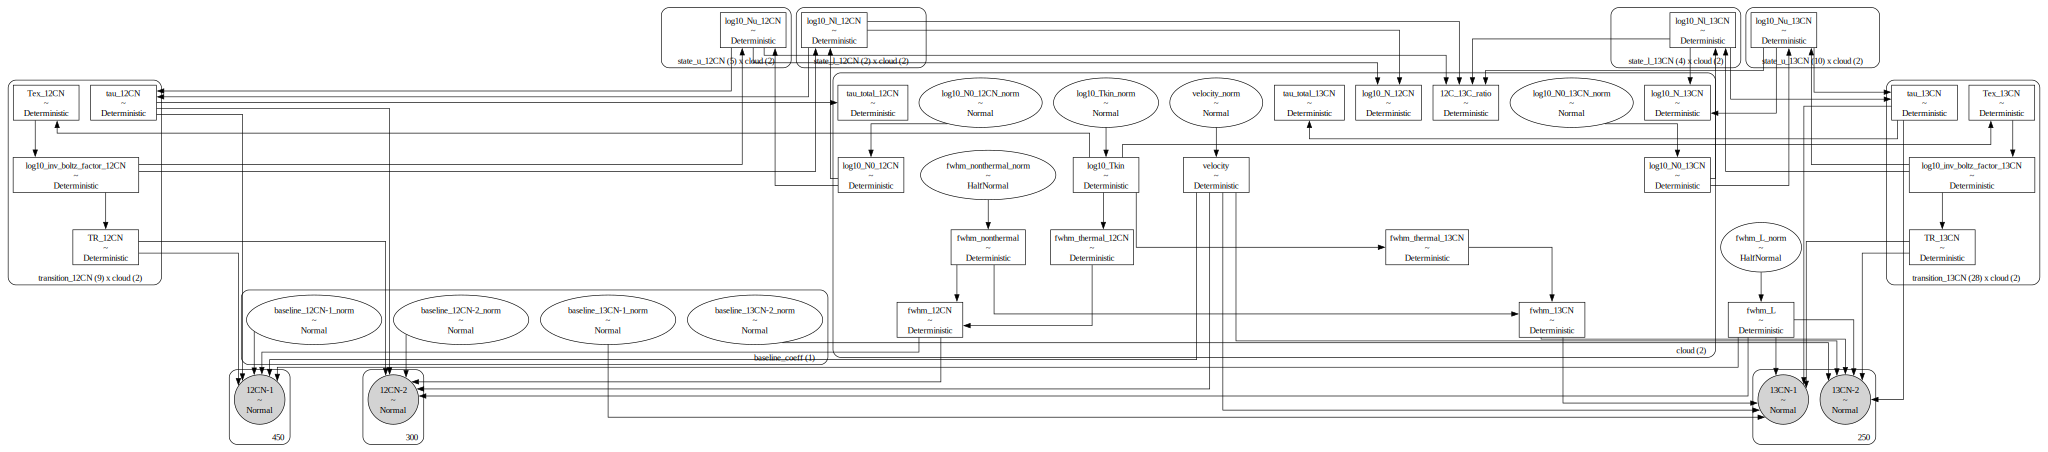

In [24]:
# Plot model graph
model.graph().render('cn_ratio_model', format='png')
model.graph()

In [25]:
# model string representation
print(model.model.str_repr())

       baseline_12CN-1_norm ~ Normal(0, 1)
       baseline_12CN-2_norm ~ Normal(0, 1)
       baseline_13CN-1_norm ~ Normal(0, 1)
       baseline_13CN-2_norm ~ Normal(0, 1)
              velocity_norm ~ Normal(0, 1)
            log10_Tkin_norm ~ Normal(0, 1)
       fwhm_nonthermal_norm ~ HalfNormal(0, 1)
                fwhm_L_norm ~ HalfNormal(0, 1)
         log10_N0_12CN_norm ~ Normal(0, 1)
         log10_N0_13CN_norm ~ Normal(0, 1)
                   velocity ~ Deterministic(f(velocity_norm))
                 log10_Tkin ~ Deterministic(f(log10_Tkin_norm))
          fwhm_thermal_12CN ~ Deterministic(f(log10_Tkin_norm))
          fwhm_thermal_13CN ~ Deterministic(f(log10_Tkin_norm))
            fwhm_nonthermal ~ Deterministic(f(fwhm_nonthermal_norm))
                  fwhm_12CN ~ Deterministic(f(fwhm_nonthermal_norm, log10_Tkin_norm))
                  fwhm_13CN ~ Deterministic(f(fwhm_nonthermal_norm, log10_Tkin_norm))
                     fwhm_L ~ Deterministic(f(fwhm_L_norm))
       

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N0_12CN_norm, log10_N0_13CN_norm, log10_Tkin_norm, velocity_norm]


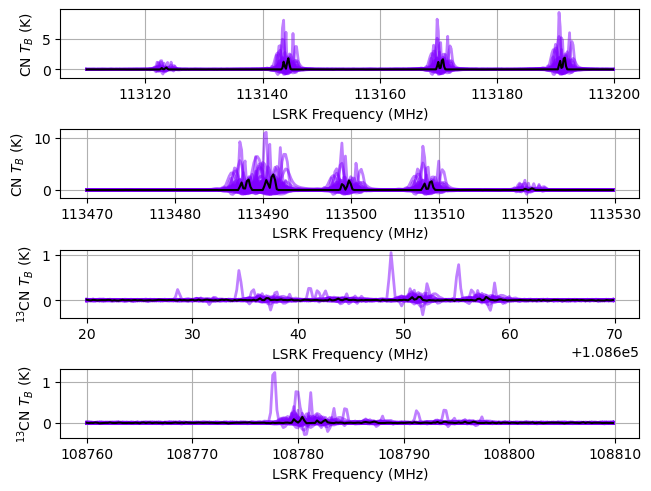

In [26]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

In [27]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.05, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 7400
Interrupted at 7,399 [7%]: Average Loss = 1.7709e+05


Output()

Runtime: 2.64 minutes


In [28]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_free_12CN", "transition_12CN", "transition_13CN", "state_l_12CN", "state_l_13CN"]
    ))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]                 1.503  0.001   1.502    1.505      0.000    0.000   
velocity[1]                -0.520  0.001  -0.521   -0.518      0.000    0.000   
log10_Tkin[0]               0.700  0.000   0.700    0.701      0.000    0.000   
log10_Tkin[1]               0.800  0.000   0.799    0.800      0.000    0.000   
fwhm_thermal_12CN[0]        0.094  0.000   0.094    0.094      0.000    0.000   
fwhm_thermal_12CN[1]        0.105  0.000   0.105    0.105      0.000    0.000   
fwhm_thermal_13CN[0]        0.092  0.000   0.092    0.092      0.000    0.000   
fwhm_thermal_13CN[1]        0.103  0.000   0.103    0.103      0.000    0.000   
fwhm_nonthermal[0]          0.501  0.002   0.498    0.504      0.000    0.000   
fwhm_nonthermal[1]          0.803  0.001   0.801    0.805      0.000    0.000   
fwhm_12CN[0]                0.510  0.002   0.507    0.513      0.000    0.000   
fwhm_12CN[1]                0.810  0.001   0.808    0.812      0.000    0.000   
fwhm_13CN[0]                0.510  0.002   0.507    0.513      0.000    0.000   
fwhm_13CN[1]                0.809  0.001   0.807    0.811      0.000    0.000   
log10_N0_12CN[0]           13.496  0.001  13.495   13.498      0.000    0.000   
log10_N0_12CN[1]           13.601  0.001  13.600   13.602      0.000    0.000   
log10_N0_13CN[0]           11.491  0.016  11.461   11.519      0.001    0.000   
log10_N0_13CN[1]           11.604  0.009  11.587   11.620      0.000    0.000   
log10_Nu_12CN[1 0 1 2, 0]  13.026  0.001  13.024   13.027      0.000    0.000   
log10_Nu_12CN[1 0 1 2, 1]  13.227  0.001  13.226   13.228      0.000    0.000   
log10_Nu_12CN[1 0 1 1, 0]  12.725  0.001  12.723   12.727      0.000    0.000   
log10_Nu_12CN[1 0 1 1, 1]  12.926  0.001  12.925   12.927      0.000    0.000   
log10_Nu_12CN[1 0 2 1, 0]  12.723  0.001  12.721   12.725      0.000    0.000   
log10_Nu_12CN[1 0 2 1, 1]  12.925  0.001  12.923   12.926      0.000    0.000   
log10_Nu_12CN[1 0 2 2, 0]  13.024  0.001  13.022   13.026      0.000    0.000   
log10_Nu_12CN[1 0 2 2, 1]  13.226  0.001  13.225   13.227      0.000    0.000   
log10_Nu_12CN[1 0 2 3, 0]  13.200  0.001  13.198   13.202      0.000    0.000   
log10_Nu_12CN[1 0 2 3, 1]  13.402  0.001  13.401   13.403      0.000    0.000   
log10_N_12CN[0]            13.976  0.001  13.974   13.978      0.000    0.000   
log10_N_12CN[1]            14.132  0.001  14.131   14.133      0.000    0.000   
tau_total_12CN[0]           3.050  0.007   3.037    3.063      0.000    0.000   
tau_total_12CN[1]           3.389  0.005   3.379    3.397      0.000    0.000   
log10_Nu_13CN[1 1 1 1, 0]  11.037  0.016  11.006   11.065      0.001    0.000   
log10_Nu_13CN[1 1 1 1, 1]  11.243  0.009  11.226   11.259      0.000    0.000   
log10_Nu_13CN[1 2 2 3, 0]  11.405  0.016  11.374   11.433      0.001    0.000   
log10_Nu_13CN[1 2 2 3, 1]  11.611  0.009  11.593   11.627      0.000    0.000   
log10_Nu_13CN[1 2 1 0, 0]  10.562  0.016  10.532   10.591      0.001    0.000   
log10_Nu_13CN[1 2 1 0, 1]  10.768  0.009  10.750   10.784      0.000    0.000   
log10_Nu_13CN[1 2 2 1, 0]  11.037  0.016  11.006   11.065      0.001    0.000   
log10_Nu_13CN[1 2 2 1, 1]  11.243  0.009  11.225   11.259      0.000    0.000   
log10_Nu_13CN[1 2 1 2, 0]  11.261  0.016  11.231   11.289      0.001    0.000   
log10_Nu_13CN[1 2 1 2, 1]  11.467  0.009  11.449   11.483      0.000    0.000   
log10_Nu_13CN[1 1 1 0, 0]  10.560  0.016  10.529   10.588      0.001    0.000   
log10_Nu_13CN[1 1 1 0, 1]  10.766  0.009  10.749   10.782      0.000    0.000   
log10_Nu_13CN[1 1 1 2, 0]  11.259  0.016  11.228   11.287      0.001    0.000   
log10_Nu_13CN[1 1 1 2, 1]  11.465  0.009  11.448   11.481      0.000    0.000   
log10_Nu_13CN[1 1 0 1, 0]  11.038  0.016  11.007   11.066      0.001    0.000   
log10_Nu_13CN[1 1 0 1, 1]  11.244  0.009  11.226   11.260      0.000    0.000   
log10_Nu_13CN[1 2 2 2, 0]  11.258  0.016  11.228   11.286   

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

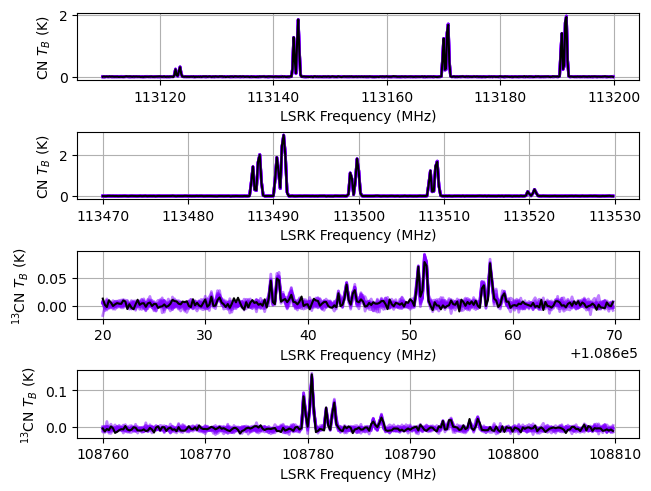

In [29]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

In [30]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.05, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 7400
Interrupted at 7,399 [7%]: Average Loss = 1.7709e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, velocity_norm, log10_Tkin_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N0_12CN_norm, log10_N0_13CN_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 293 seconds.


Adding log-likelihood to trace


Output()

Runtime: 9.12 minutes


In [32]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [33]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set([
        "transition_12CN", "transition_free_12CN", "transition_13CN",
        "state_l_12CN", "state_l_13CN"
    ]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]                 1.500  0.001   1.499    1.501      0.000    0.000   
velocity[1]                -0.500  0.000  -0.501   -0.499      0.000    0.000   
log10_Tkin[0]               0.701  0.001   0.700    0.702      0.000    0.000   
log10_Tkin[1]               0.800  0.000   0.799    0.801      0.000    0.000   
fwhm_thermal_12CN[0]        0.094  0.000   0.094    0.094      0.000    0.000   
fwhm_thermal_12CN[1]        0.105  0.000   0.105    0.105      0.000    0.000   
fwhm_thermal_13CN[0]        0.092  0.000   0.092    0.092      0.000    0.000   
fwhm_thermal_13CN[1]        0.103  0.000   0.103    0.104      0.000    0.000   
fwhm_nonthermal[0]          0.502  0.002   0.499    0.505      0.000    0.000   
fwhm_nonthermal[1]          0.800  0.001   0.798    0.802      0.000    0.000   
fwhm_12CN[0]                0.510  0.002   0.508    0.513      0.000    0.000   
fwhm_12CN[1]                0.807  0.001   0.805    0.809      0.000    0.000   
fwhm_13CN[0]                0.510  0.002   0.507    0.513      0.000    0.000   
fwhm_13CN[1]                0.807  0.001   0.804    0.809      0.000    0.000   
log10_N0_12CN[0]           13.498  0.002  13.494   13.501      0.000    0.000   
log10_N0_12CN[1]           13.601  0.001  13.599   13.603      0.000    0.000   
log10_N0_13CN[0]           11.485  0.014  11.457   11.512      0.000    0.000   
log10_N0_13CN[1]           11.605  0.009  11.589   11.623      0.000    0.000   
log10_Nu_12CN[1 0 1 2, 0]  13.028  0.002  13.025   13.030      0.000    0.000   
log10_Nu_12CN[1 0 1 2, 1]  13.227  0.001  13.225   13.229      0.000    0.000   
log10_Nu_12CN[1 0 1 1, 0]  12.727  0.002  12.724   12.730      0.000    0.000   
log10_Nu_12CN[1 0 1 1, 1]  12.926  0.001  12.925   12.928      0.000    0.000   
log10_Nu_12CN[1 0 2 1, 0]  12.725  0.002  12.722   12.728      0.000    0.000   
log10_Nu_12CN[1 0 2 1, 1]  12.925  0.001  12.923   12.927      0.000    0.000   
log10_Nu_12CN[1 0 2 2, 0]  13.026  0.002  13.023   13.029      0.000    0.000   
log10_Nu_12CN[1 0 2 2, 1]  13.226  0.001  13.224   13.228      0.000    0.000   
log10_Nu_12CN[1 0 2 3, 0]  13.203  0.002  13.200   13.206      0.000    0.000   
log10_Nu_12CN[1 0 2 3, 1]  13.402  0.001  13.401   13.404      0.000    0.000   
log10_N_12CN[0]            13.978  0.002  13.974   13.981      0.000    0.000   
log10_N_12CN[1]            14.132  0.001  14.131   14.134      0.000    0.000   
tau_total_12CN[0]           3.058  0.017   3.025    3.088      0.000    0.000   
tau_total_12CN[1]           3.390  0.012   3.367    3.411      0.000    0.000   
log10_Nu_13CN[1 1 1 1, 0]  11.032  0.014  11.003   11.057      0.000    0.000   
log10_Nu_13CN[1 1 1 1, 1]  11.244  0.009  11.228   11.262      0.000    0.000   
log10_Nu_13CN[1 2 2 3, 0]  11.399  0.014  11.371   11.425      0.000    0.000   
log10_Nu_13CN[1 2 2 3, 1]  11.612  0.009  11.595   11.629      0.000    0.000   
log10_Nu_13CN[1 2 1 0, 0]  10.557  0.014  10.528   10.583      0.000    0.000   
log10_Nu_13CN[1 2 1 0, 1]  10.769  0.009  10.752   10.787      0.000    0.000   
log10_Nu_13CN[1 2 2 1, 0]  11.031  0.014  11.002   11.057      0.000    0.000   
log10_Nu_13CN[1 2 2 1, 1]  11.244  0.009  11.227   11.261      0.000    0.000   
log10_Nu_13CN[1 2 1 2, 0]  11.256  0.014  11.227   11.281      0.000    0.000   
log10_Nu_13CN[1 2 1 2, 1]  11.468  0.009  11.451   11.485      0.000    0.000   
log10_Nu_13CN[1 1 1 0, 0]  10.554  0.014  10.526   10.580      0.000    0.000   
log10_Nu_13CN[1 1 1 0, 1]  10.767  0.009  10.751   10.785      0.000    0.000   
log10_Nu_13CN[1 1 1 2, 0]  11.253  0.014  11.225   11.279      0.000    0.000   
log10_Nu_13CN[1 1 1 2, 1]  11.466  0.009  11.450   11.484      0.000    0.000   
log10_Nu_13CN[1 1 0 1, 0]  11.033  0.014  11.004   11.058      0.000    0.000   
log10_Nu_13CN[1 1 0 1, 1]  11.245  0.009  11.228   11.262      0.000    0.000   
log10_Nu_13CN[1 2 2 2, 0]  11.253  0.014  11.224   11.279   

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

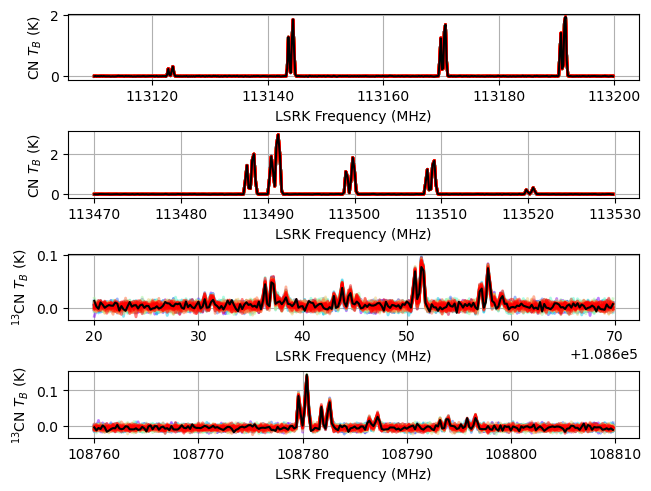

In [34]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

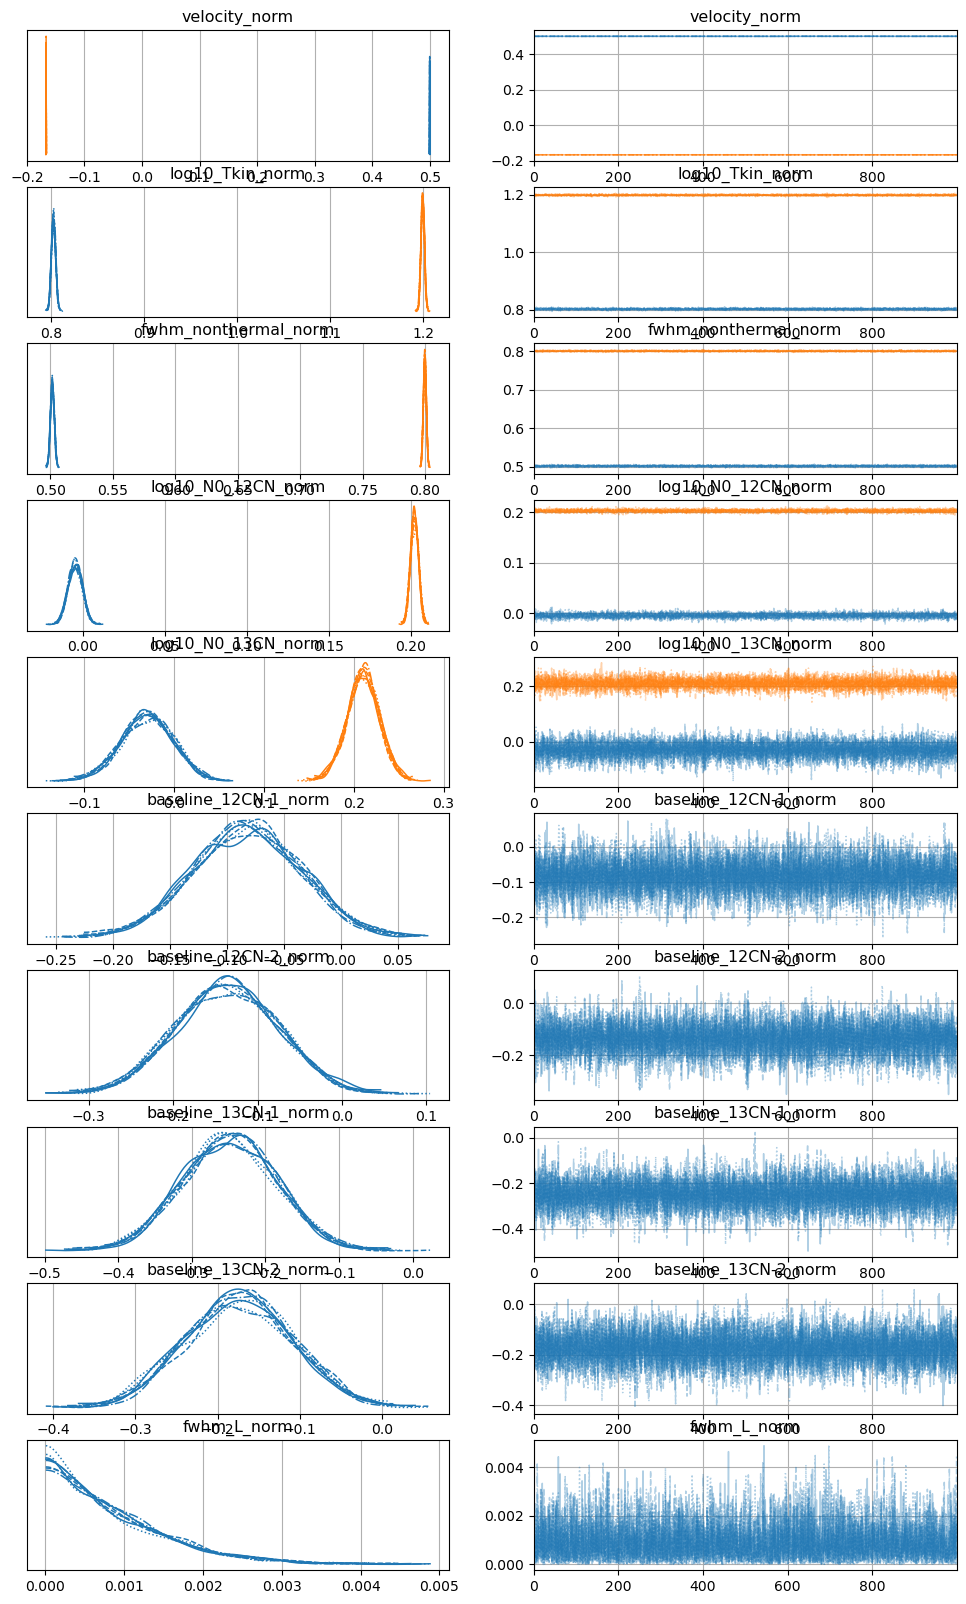

In [38]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

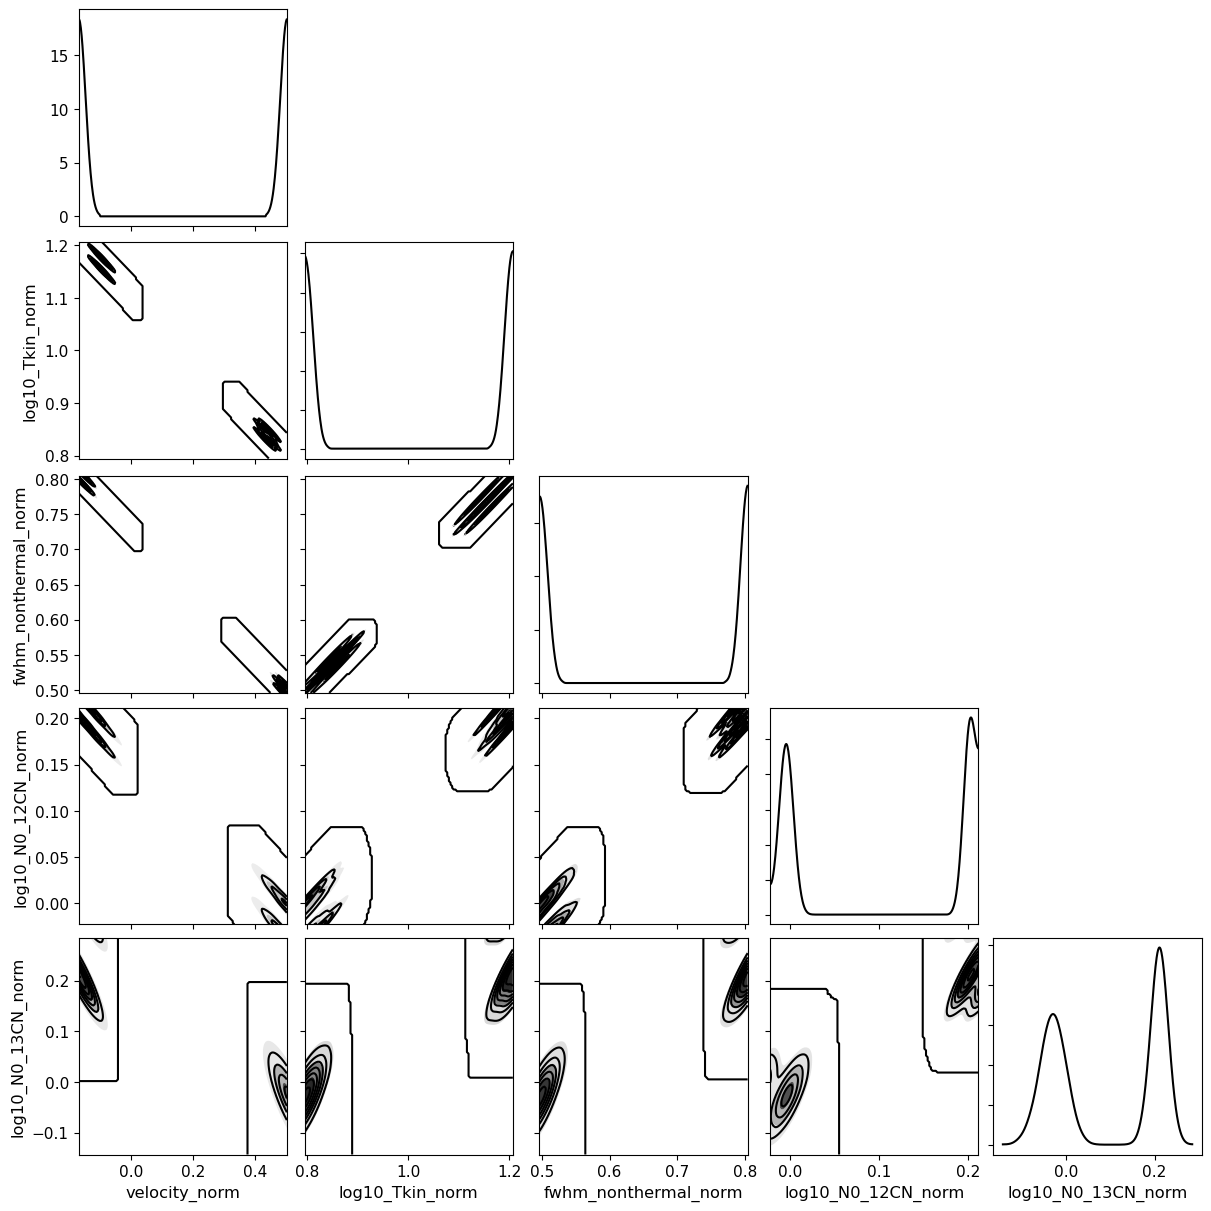

In [40]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_freeRVs
    if not set(model.model.named_vars_to_dims[param]).intersection(set([
        "transition_12CN", "transition_free_12CN", "transition_13CN", "transition_free_13CN",
        "state_l_12CN", "state_l_13CN"
    ]))
]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

['velocity', 'log10_Tkin', 'fwhm_thermal_12CN', 'fwhm_thermal_13CN', 'fwhm_nonthermal', 'fwhm_12CN', 'fwhm_13CN', 'log10_N0_12CN', 'log10_N0_13CN', 'log10_N_12CN', 'tau_total_12CN', 'log10_N_13CN', 'tau_total_13CN', '12C_13C_ratio']


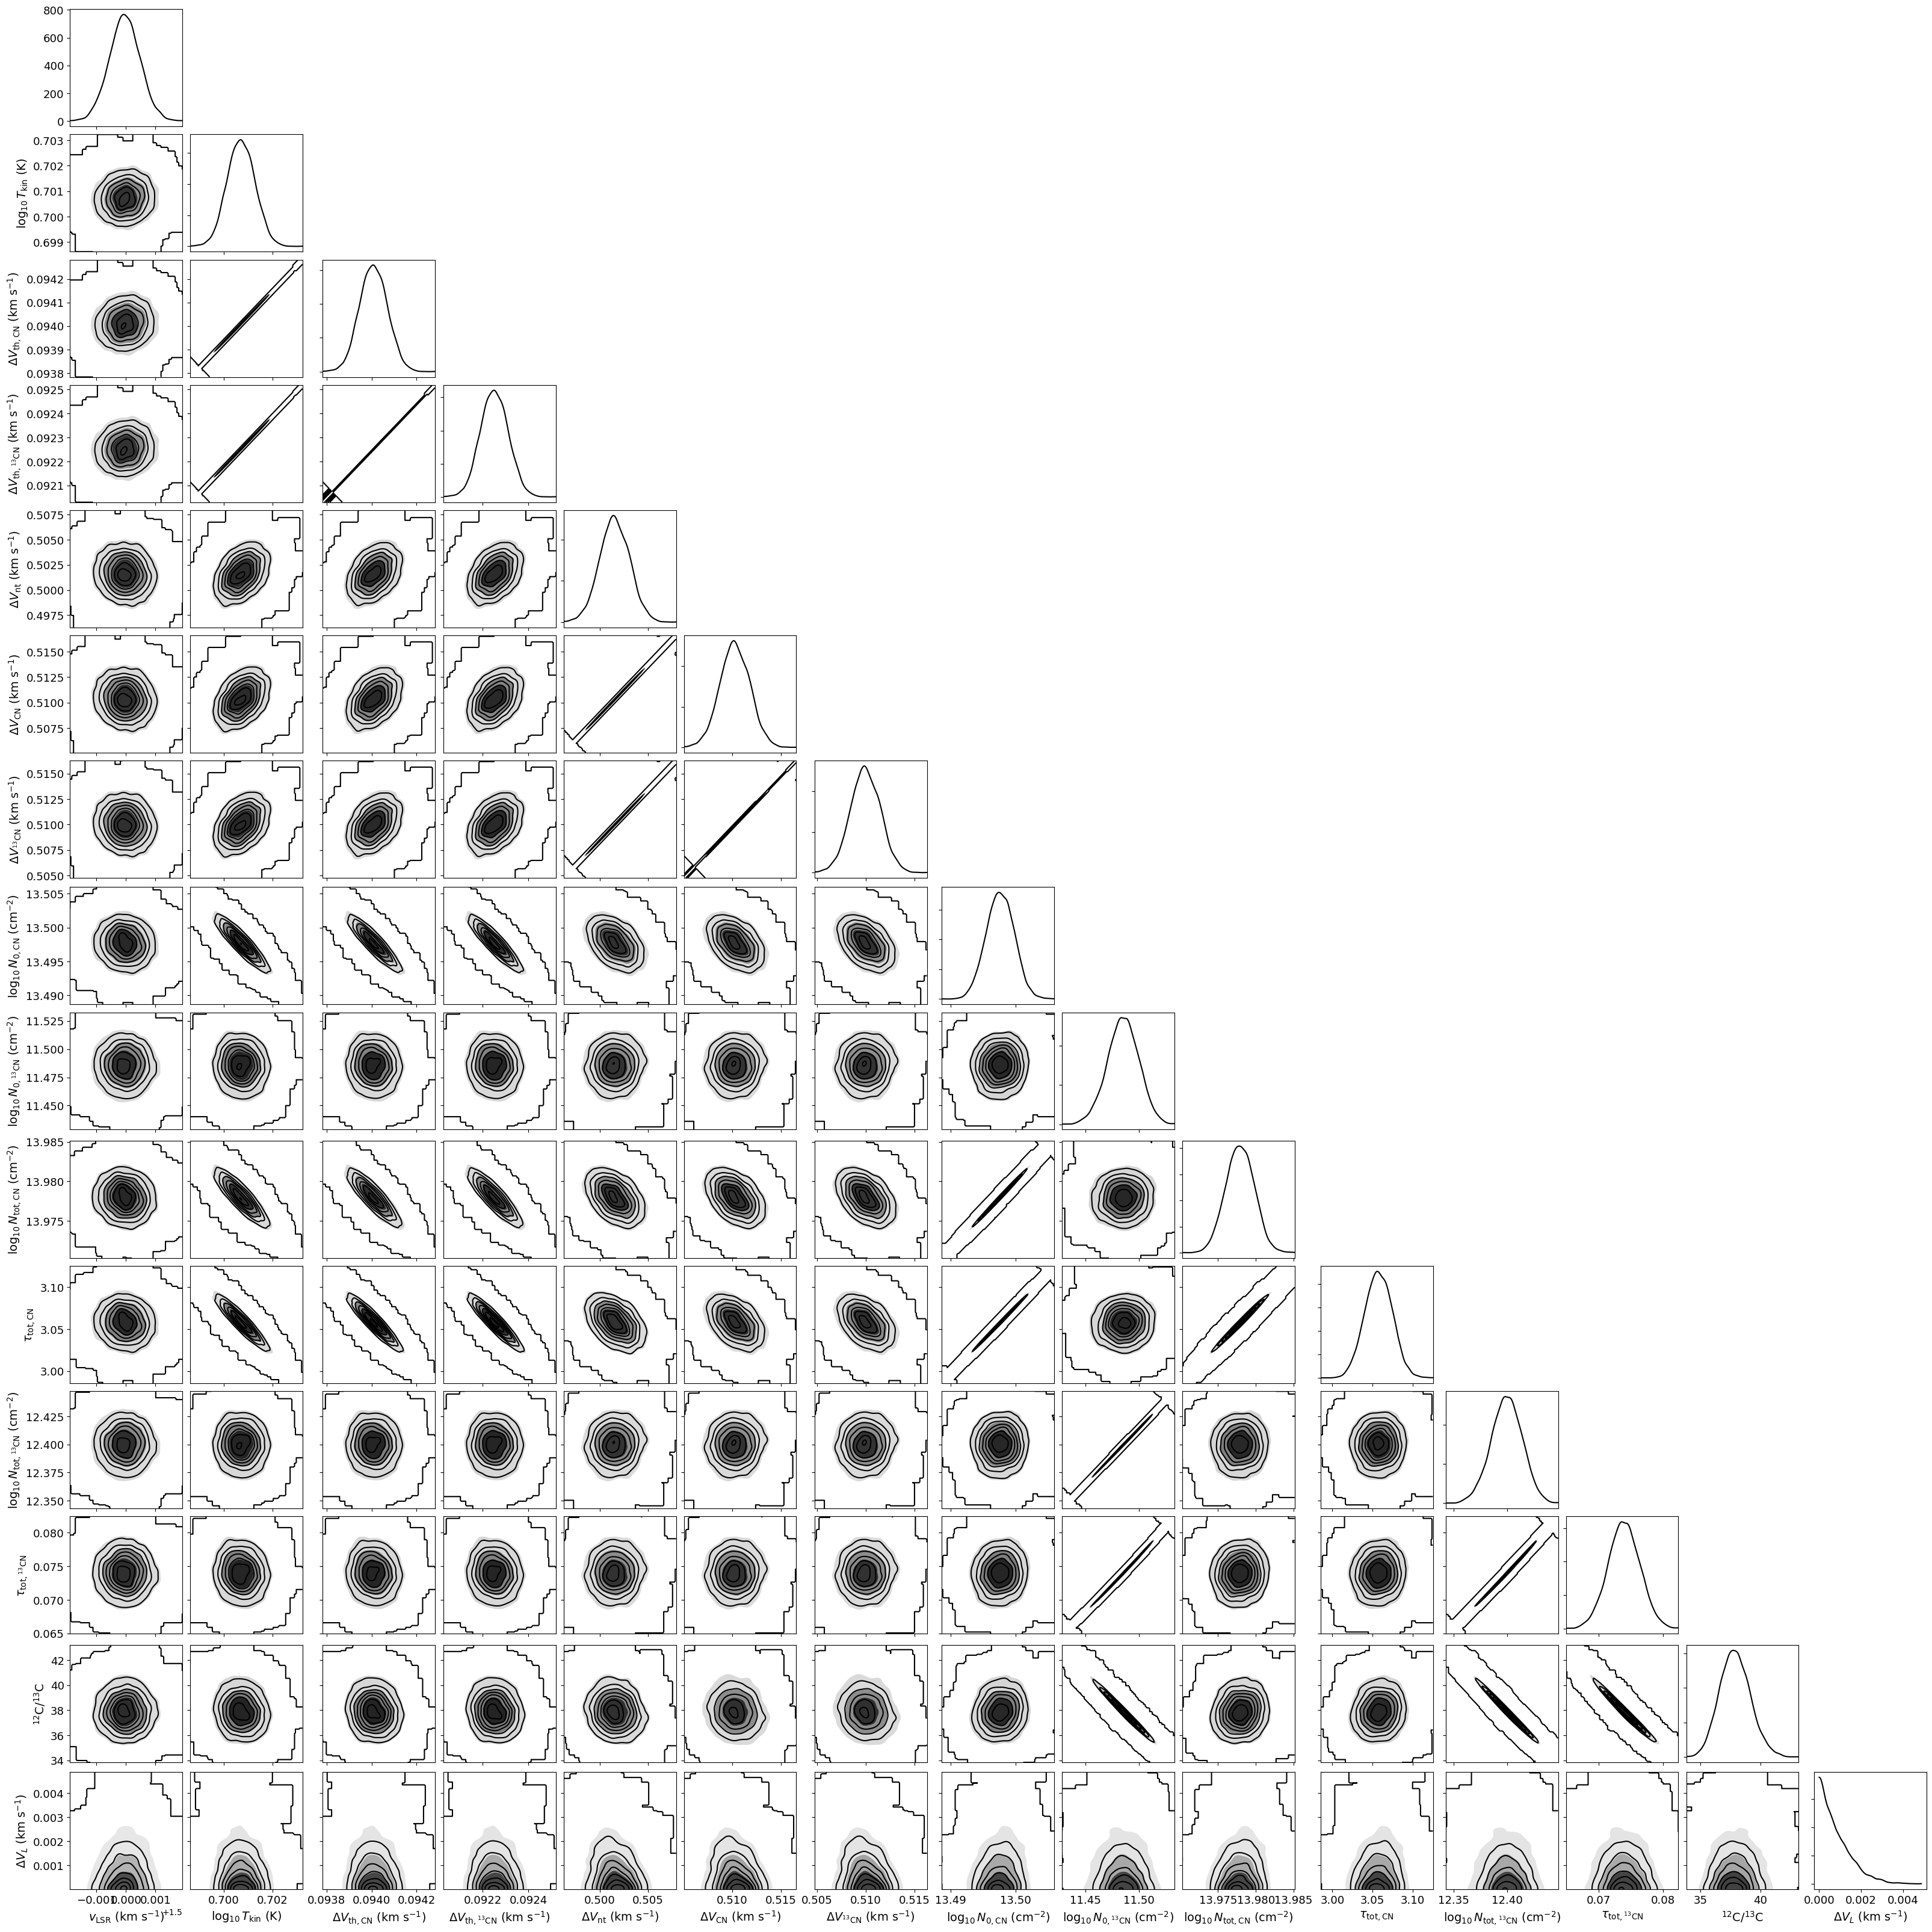

In [45]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set([
        "transition_12CN", "transition_free_12CN", "transition_13CN", "transition_free_13CN",
        "state_l_12CN", "state_l_13CN", "state_u_12CN", "state_u_13CN"
    ]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

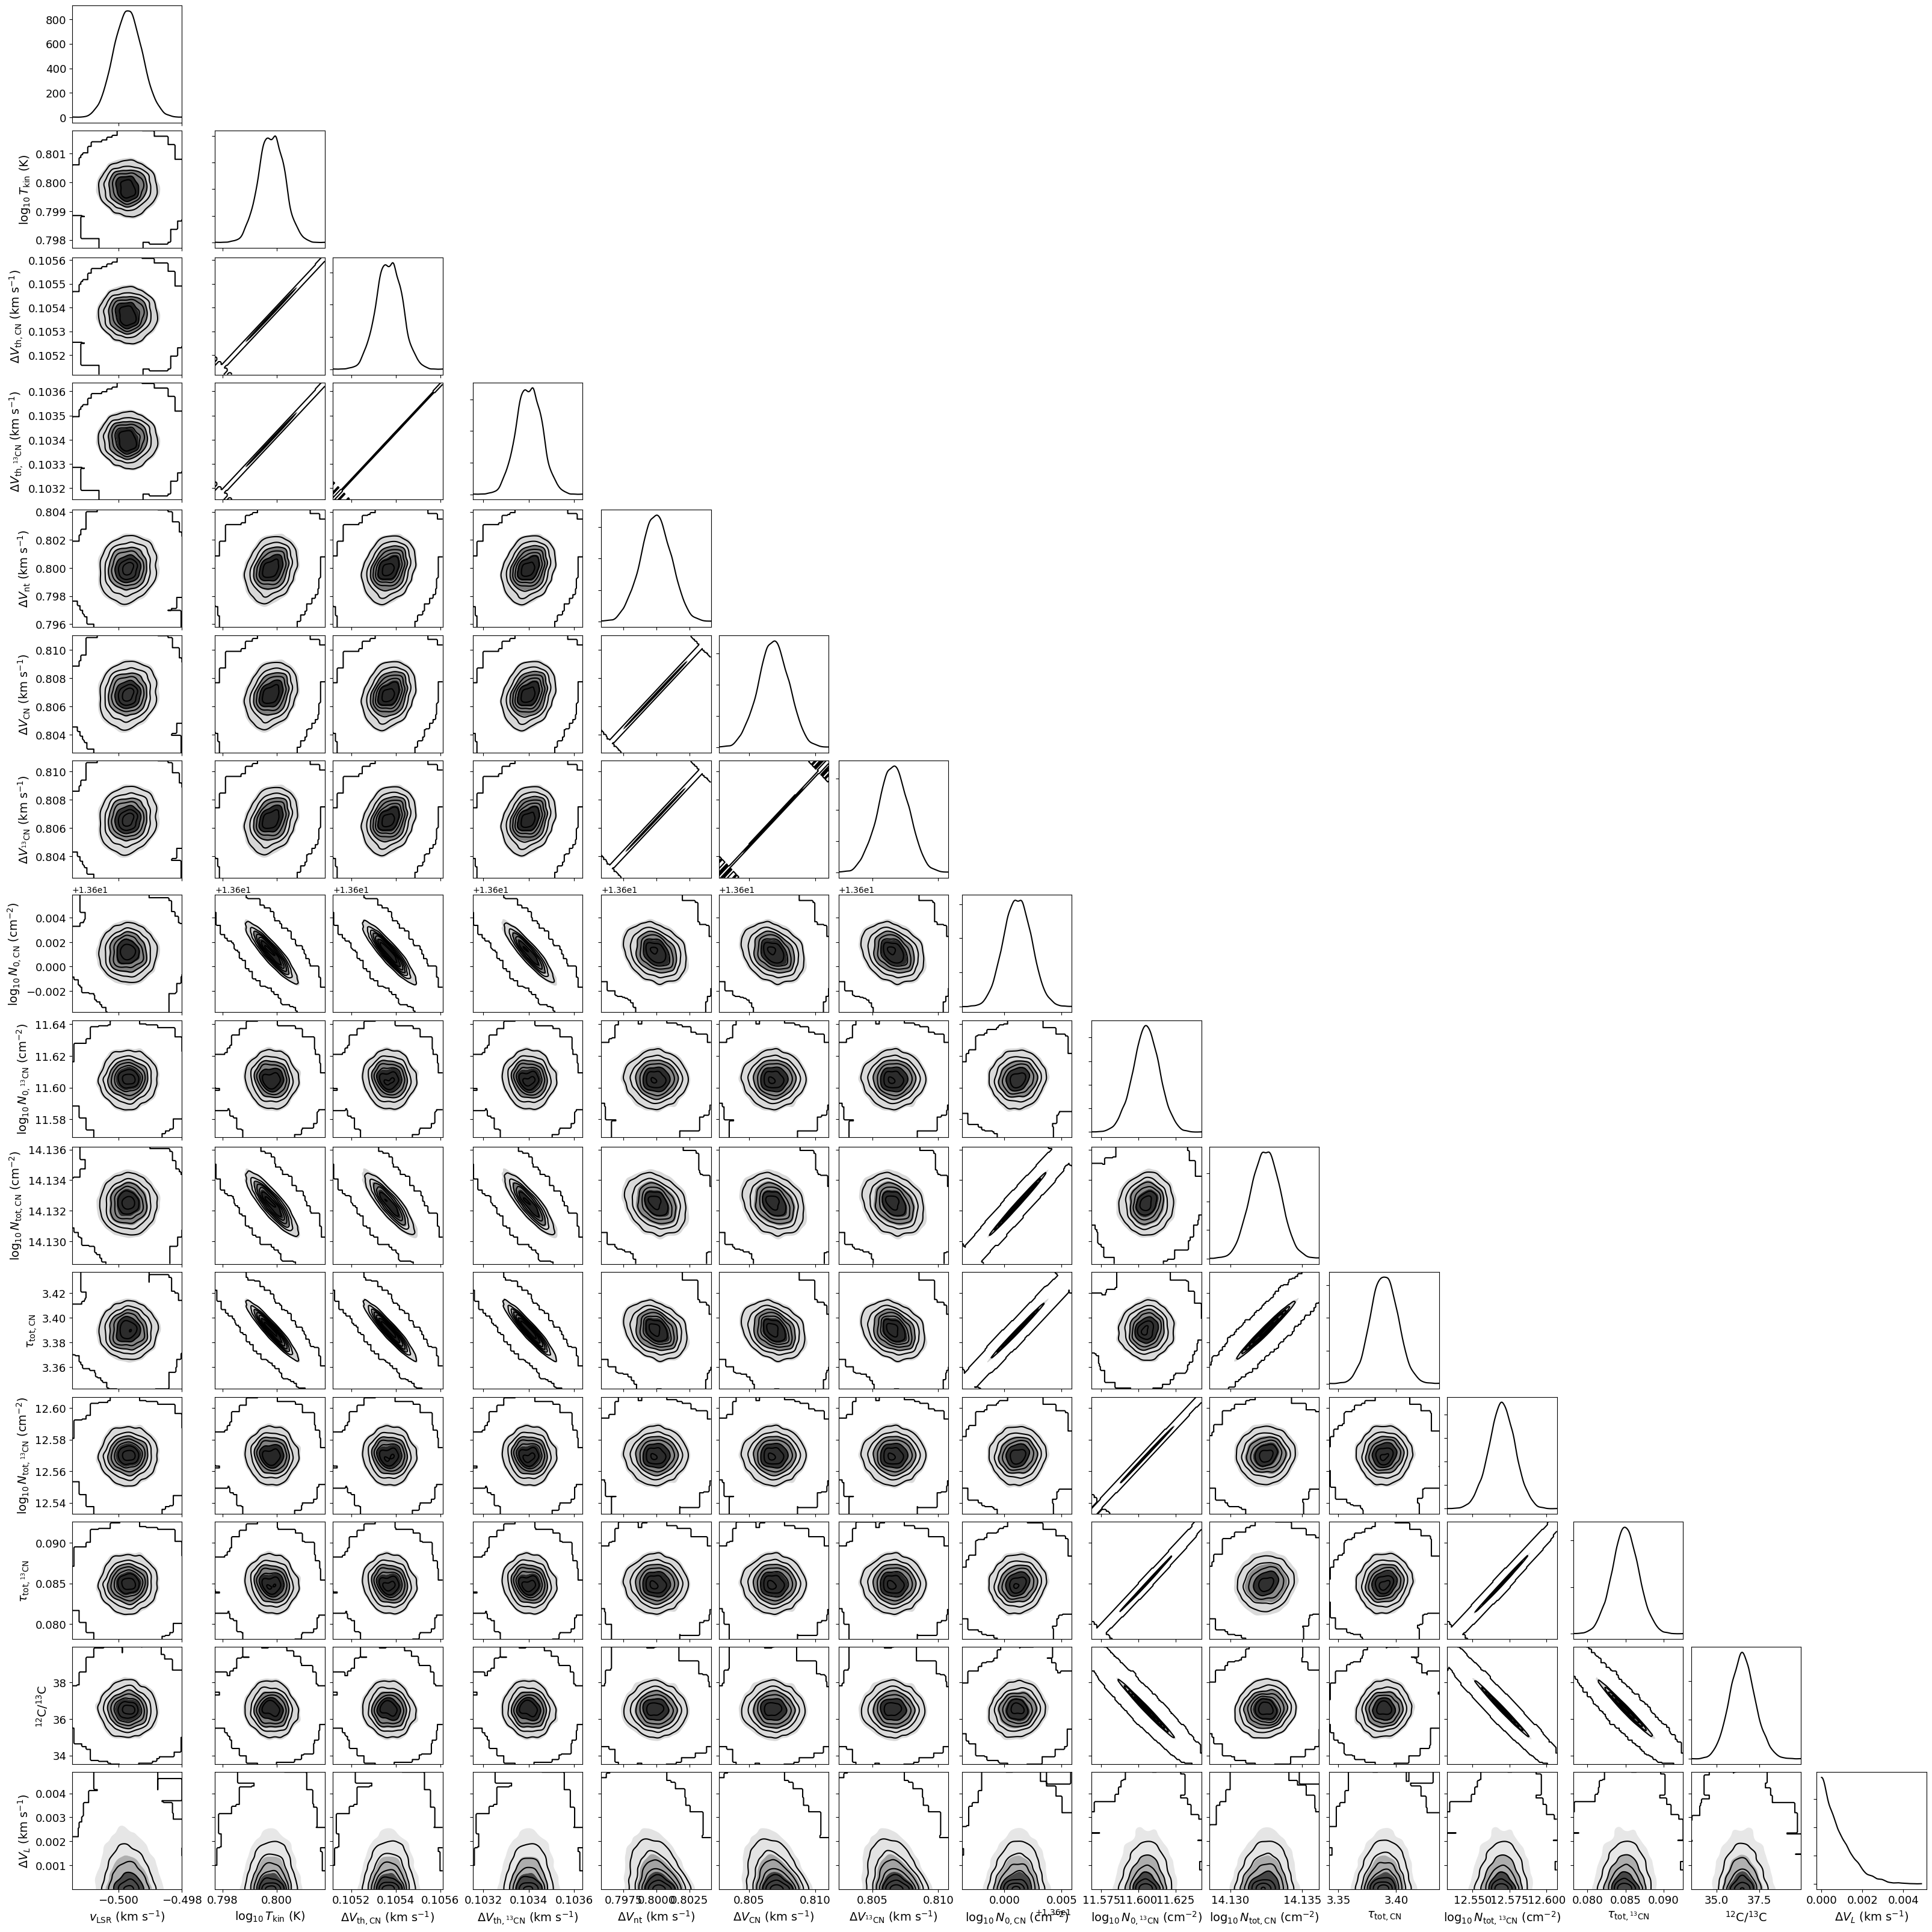

In [46]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

In [47]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_deterministics
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -9627.65033301244


mean     sd  hdi_16%  hdi_84%
velocity[0]                                   1.500  0.001    1.499    1.500
velocity[1]                                  -0.500  0.000   -0.500   -0.499
log10_Tkin[0]                                 0.701  0.001    0.700    0.701
log10_Tkin[1]                                 0.800  0.000    0.799    0.800
fwhm_thermal_12CN[0]                          0.094  0.000    0.094    0.094
fwhm_thermal_12CN[1]                          0.105  0.000    0.105    0.105
fwhm_thermal_13CN[0]                          0.092  0.000    0.092    0.092
fwhm_thermal_13CN[1]                          0.103  0.000    0.103    0.103
fwhm_nonthermal[0]                            0.502  0.002    0.500    0.503
fwhm_nonthermal[1]                            0.800  0.001    0.799    0.801
fwhm_12CN[0]                                  0.510  0.002    0.509    0.512
fwhm_12CN[1]                                  0.807  0.001    0.806    0.808
fwhm_13CN[0]                                  0.510  0.002    0.508    0.511
fwhm_13CN[1]                                  0.807  0.001    0.806    0.808
log10_N0_12CN[0]                             13.498  0.002   13.496   13.500
log10_N0_12CN[1]                             13.601  0.001   13.600   13.602
log10_N0_13CN[0]                             11.485  0.014   11.471   11.499
log10_N0_13CN[1]                             11.605  0.009   11.597   11.614
Tex_12CN[113123.3687, 0]                      5.020  0.007    5.013    5.026
Tex_12CN[113123.3687, 1]                      6.307  0.007    6.300    6.314
Tex_12CN[113144.19, 0]                        5.020  0.007    5.013    5.026
Tex_12CN[113144.19, 1]                        6.307  0.007    6.300    6.314
Tex_12CN[113170.535, 0]                       5.020  0.007    5.013    5.026
Tex_12CN[113170.535, 1]                       6.307  0.007    6.300    6.314
Tex_12CN[113191.325, 0]                       5.020  0.007    5.013    5.026
Tex_12CN[113191.325, 1]                       6.307  0.007    6.300    6.314
Tex_12CN[113488.142, 0]                       5.020  0.007    5.013    5.026
Tex_12CN[113488.142, 1]                       6.307  0.007    6.300    6.314
Tex_12CN[113490.985, 0]                       5.020  0.007    5.013    5.026
Tex_12CN[113490.985, 1]                       6.307  0.007    6.300    6.314
Tex_12CN[113499.643, 0]                       5.020  0.007    5.013    5.026
Tex_12CN[113499.643, 1]                       6.307  0.007    6.300    6.314
Tex_12CN[113508.934, 0]                       5.020  0.007    5.013    5.026
Tex_12CN[113508.934, 1]                       6.307  0.007    6.300    6.314
Tex_12CN[113520.4215, 0]                      5.020  0.007    5.013    5.026
Tex_12CN[113520.4215, 1]                      6.307  0.007    6.300    6.314
log10_inv_boltz_factor_12CN[113123.3687, 0]   0.470  0.001    0.469    0.470
log10_inv_boltz_factor_12CN[113123.3687, 1]   0.374  0.000    0.373    0.374
log10_inv_boltz_factor_12CN[113144.19, 0]     0.470  0.001    0.469    0.470
log10_inv_boltz_factor_12CN[113144.19, 1]     0.374  0.000    0.374    0.374
log10_inv_boltz_factor_12CN[113170.535, 0]    0.470  0.001    0.469    0.470
log10_inv_boltz_factor_12CN[113170.535, 1]    0.374  0.000    0.374    0.374
log10_inv_boltz_factor_12CN[113191.325, 0]    0.470  0.001    0.469    0.471
log10_inv_boltz_factor_12CN[113191.325, 1]    0.374  0.000    0.374    0.374
log10_inv_boltz_factor_12CN[113488.142, 0]    0.471  0.001    0.471    0.472
log10_inv_boltz_factor_12CN[113488.142, 1]    0.375  0.000    0.375    0.375
log10_inv_boltz_factor_12CN[113490.985, 0]    0.471  0.001    0.471    0.472
log10_inv_boltz_factor_12CN[113490.985, 1]    0.375  0.000    0.375    0.375
log10_inv_boltz_factor_12CN[113499.643, 0]    0.471  0.001    0.471    0.472
log10_inv_boltz_factor_12CN[113499.643, 1]    0.375  0.000    0.375    0.375
log10_inv_boltz_factor_12CN[113508.934, 0]    0.471  0.001    0.471    0.472
log10_inv_boltz_factor_12CN[113508.934, 1] 

In [48]:
print(sim_params)
print(derived_params)

{'log10_N0_12CN': [13.5, 13.6], 'log10_N0_13CN': [11.5, 11.6], 'log10_Tkin': [0.7, 0.8], 'velocity': [1.5, -0.5], 'fwhm_nonthermal': [0.5, 0.8], 'fwhm_L': 0.0, 'baseline_12CN_norm': [0.0], 'baseline_13CN_norm': [0.0]}
{'log10_N_12CN': array([13.97989297, 14.1314017 ]), 'tau_total_12CN': array([3.07715427, 3.3798474 ]), 'log10_N_13CN': array([12.41407039, 12.56473427]), 'tau_total_13CN': array([0.07656949, 0.08390171]), '12C_13C_ratio': array([36.7978613 , 36.86951594])}
